# **Mission of the classification notebook**

Picture yourself as a data scientist sitting with executives from SpaceX who have received reports that several of their astronauts are complaining of vision impairment.  In order to do a full investigation, their medical team decided to use minimally-invasive [intraocular fine needle aspiration](https://pubmed.ncbi.nlm.nih.gov/8233394/) to take biopsies from the astronauts and their ground-control counterparts.  Using this tissue, they were able to perform immunostaining microscopy as well as RNA sequencing.  They were also able to obtain intraocular pressure measurements from both the astronauts and their ground-control counterparts.  

Your goal is to determine if there are [biological pathways](https://en.wikipedia.org/wiki/Biological_pathway) that are responding to conditions in space, because if so, there may be a molecular target that can be used to diagnose, monitor, and/or treat this condition.  But first you must determine if there's any association at all between the RNA-seq gene expression data and the measurements obtained from their medical team.  Your mission is to evaluate the use of random forest and single-layer perceptron classification algorithms to determine if the genes expressed in the retinal tissue are predictive of the phenotypic responses that were observed.  You are also encouraged to try the [logistic regression algorithm](https://en.wikipedia.org/wiki/Logistic_regression) for the same.



# Read in the methods

Recall that we have put all the custom python methods in a separate notebook which you copied to your Google drive.  We need to read those methods into this notebook so that we can use them here.  You will get prompted to select the gmail address to use to permit access to your google drive for this notebook.

Note that we will import the methods in the notebook as "m", so all subsequent references to methods in that notebook will be prefixed with "m.".

**IMPORTANT**: Make sure you put a copy of the methods.ipynb in your google drive by following [these instructions](https://docs.google.com/document/d/1V9a3Z5YKT2Pbef4fgPAwB83bHX-p-rPBRRwo7w5Bi9k/edit?usp=sharing).

In [1]:
# install and import the python module for importing a notebook
!pip install import_ipynb
import import_ipynb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.1 MB/s eta 0:00:00


In [2]:
# mount your google drive to this notebook
from google.colab import drive
drive.flush_and_unmount()
drive.mount("mnt", force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at mnt


In [4]:
# import the "Copy of methods.ipynb" from your google drive into this notebook
m = __import__("mnt/MyDrive/Colab Notebooks/methods1")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 247.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 208.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 246.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 202.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 233.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=8b09124cd86987112c317cb218e320f928c36bfa2c7f98f97226987ecc6d436a
  Stored in directory: /tmp/pip-ephem-wheel-cache-q9_fom9q/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.9/552.9 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# read in the data

After reading in the methods, we need to read in the data from the NASA OSDR space biology data repository.  In this notebook, we will  be using the immunostaining microscopy PECAM data from OSD-568, the RNA-seq data from OSD-255, and the tonometry data from OSD-583.

After reading in the data from OSDR, we will reduce the dimensions of the RNA-seq data to include only those genes whose [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) is greater than a threshold. This is a form of [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) that will remove some noise from the gene expression so our classification algorithms can focus on the signal.  

In [5]:
# define dictionaries for data and metadata
data=dict()
metadata=dict()

In [6]:
# read in metadata
metadata['255'] = m.read_meta_data('255')
metadata['568'] = m.read_meta_data('568')
metadata['583'] = m.read_meta_data('583')

In [7]:
# read in tonometry transformed data from OSD-583
data['iop'] = m.read_phenotype_data('583', 'LSDS-16_tonometry_maoTRANSFORMED')
print('num samples: ', str(len(list(data['iop']['Sample Name']))))
print('samples: ', list(data['iop']['Sample Name']))
data['iop'].head()

num samples:  100
samples:  ['F1_Mouse_Eye', 'F2_Mouse_Eye', 'F3_Mouse_Eye', 'F4_Mouse_Eye', 'F5_Mouse_Eye', 'F6_Mouse_Eye', 'F7_Mouse_Eye', 'F8_Mouse_Eye', 'F9_Mouse_Eye', 'F10_Mouse_Eye', 'F11_Mouse_Eye', 'F12_Mouse_Eye', 'F13_Mouse_Eye', 'F14_Mouse_Eye', 'F15_Mouse_Eye', 'F16_Mouse_Eye', 'F17_Mouse_Eye', 'F18_Mouse_Eye', 'F19_Mouse_Eye', 'F20_Mouse_Eye', 'FViv1_CC1_Mouse_Eye', 'FViv2_CC1_Mouse_Eye', 'FViv3_CC1_Mouse_Eye', 'FViv4_CC1_Mouse_Eye', 'FViv5_CC1_Mouse_Eye', 'FViv6_CC1_Mouse_Eye', 'FViv7_CC1_Mouse_Eye', 'FViv8_CC1_Mouse_Eye', 'FViv9_CC1_Mouse_Eye', 'FViv10_CC1_Mouse_Eye', 'FViv11_CC1_Mouse_Eye', 'FViv12_CC1_Mouse_Eye', 'FViv13_CC1_Mouse_Eye', 'FViv14_CC1_Mouse_Eye', 'FViv15_CC1_Mouse_Eye', 'FViv16_CC1_Mouse_Eye', 'FViv17_CC1_Mouse_Eye', 'FViv18_CC1_Mouse_Eye', 'FViv19_CC1_Mouse_Eye', 'FViv20_CC1_Mouse_Eye', 'GC1_Mouse_Eye', 'GC2_Mouse_Eye', 'GC3_Mouse_Eye', 'GC4_Mouse_Eye', 'GC5_Mouse_Eye', 'GC6_Mouse_Eye', 'GC7_Mouse_Eye', 'GC8_Mouse_Eye', 'GC9_Mouse_Eye', 'GC10_Mouse_Eye'

,Source Name,Sample Name,Factor Value: Spaceflight,Left_1,Left_2,Left_3,Avg_Left,Right_1,Right_2,Right_3,Avg_Right,time_Start,Time_End
0,F1,F1_Mouse_Eye,Space Flight,19,16,18,17.666667,18,18,15,17.000000,2:46,2:48
1,F2,F2_Mouse_Eye,Space Flight,17,16,16,16.333333,16,16,15,15.666667,2:55,2:58
2,F3,F3_Mouse_Eye,Space Flight,16,18,15,16.333333,17,19,17,17.666667,2:32,2:34
3,F4,F4_Mouse_Eye,Space Flight,18,15,16,16.333333,18,16,15,16.333333,2:15,2:17
4,F5,F5_Mouse_Eye,Space Flight,18,18,16,17.333333,14,16,14,14.666667,2:20,2:22


In [8]:
# read in the immunostaining PECAM microscopy data from OSD-568
data['immunoMICRO-PECAM'] = m.read_phenotype_data('568', 'LSDS-5_immunostaining_microscopy_PECAMtr_TRANSFORMED')
print('num records: ', len(data['immunoMICRO-PECAM']))
data['immunoMICRO-PECAM'].head()

num records:  11


,Sample_Name,Average
0,F15_Mouse_Eye,45.0098
1,F16_Mouse_Eye,53.9888
2,F17_Mouse_Eye,37.0548
3,F18_Mouse_Eye,67.0988
4,F19_Mouse_Eye,49.7456


In [9]:
# use m.read_rnaseq_data() to read in the normalized transcriptomic counts from OSD-255
data['255-normalized'] = m.read_rnaseq_data('255_rna_seq_Normalized_Counts')
data['255-normalized'].head()

,Unnamed: 0,GSM3932693,GSM3932694,GSM3932695,GSM3932696,GSM3932697,GSM3932698,GSM3932699,GSM3932700,GSM3932701,GSM3932702,GSM3932703,GSM3932704,GSM3932705,GSM3932706,GSM3932707,GSM3932708
0,ENSMUSG00000000001,265.491507,272.529585,264.891134,245.804042,205.478969,244.866957,250.587443,232.249604,241.739792,240.866309,278.344274,266.781019,238.447580,239.632932,242.777557,257.121918
1,ENSMUSG00000000028,22.737528,36.058646,30.659868,33.307123,11.896920,27.231801,21.727401,30.940275,34.840848,36.468997,29.993641,28.377921,19.433721,18.704883,26.226110,47.521611
2,ENSMUSG00000000031,5.574720,1.925595,2.899933,21.047427,0.000000,3.063051,7.105655,6.710188,3.266199,6.700680,1.852027,1.308210,2.248341,5.816845,2.041330,1.478741
3,ENSMUSG00000000037,14.601777,17.493816,16.577920,32.447456,12.940934,13.678983,9.358027,15.476949,25.085866,13.506677,24.809501,13.731740,21.564524,17.626982,28.873796,13.556234
4,ENSMUSG00000000049,3.107115,2.176549,0.642689,4.486992,0.895108,3.846941,2.640744,0.000000,0.000000,1.243833,0.000000,0.000000,1.676701,1.345919,0.769123,0.684388


In [10]:
# filter genes to those significantly differentially expressed between ground control and space flight
rna_seq = m.filter_by_dgea(data['255-normalized'], metadata['255'],  pval=0.05, l2fc=0)
print('rna_seq data shape: ', rna_seq.shape)

Fitting size factors...
... done in 0.08 seconds.

Fitting dispersions...
... done in 37.96 seconds.

Fitting dispersion trend curve...
... done in 1.52 seconds.

Fitting MAP dispersions...
... done in 44.05 seconds.

Fitting LFCs...
... done in 19.74 seconds.

Calculating cook's distance...
... done in 0.06 seconds.

Replacing 294 outlier genes.

Fitting dispersions...
... done in 0.41 seconds.

Fitting MAP dispersions...
... done in 0.42 seconds.

Fitting LFCs...
... done in 0.28 seconds.

Running Wald tests...
... done in 7.97 seconds.



Log2 fold change & Wald test p-value: condition 0 vs 1
                      baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSMUSG00000000001  247.799812       -0.018393  0.073619 -0.249837  0.802713   
ENSMUSG00000000028   27.844661       -0.175417  0.251489 -0.697513  0.485482   
ENSMUSG00000000031    4.111510        1.098824  0.720941  1.524152  0.127471   
ENSMUSG00000000037   17.569248       -0.267676  0.292810 -0.914163  0.360631   
ENSMUSG00000000049    1.058677        2.166938  1.289496  1.680453  0.092869   
...                        ...             ...       ...       ...       ...   
ENSMUSG00002076937    3.364061       -1.001464  0.889246 -1.126194  0.260083   
ENSMUSG00002076945    1.308321        0.414447  1.081399  0.383250  0.701534   
ENSMUSG00002076971    0.684746        0.261245  1.815131  0.143926  0.885559   
ENSMUSG00002076982    0.685585       -0.263624  1.350536 -0.195200  0.845237   
ENSMUSG00002076983    0.810512       -1.684478  1.616810 -1.04185

**QUESTIONS**

1. How many genes in the RNA-seq dataset were there before filtering on the coefficient of variation? After filtering?

2. How many samples have IOP measurements? PECAM measurements?

3. What is the name of the column in the PECAM data that we will be using as a phenotype measurement?

# Predict intraocular pressure (IOP) from RNA-seq (gene expression) data

Not all the samples with IOP measurements had their RNA sequenced.  We will need to first subset the IOP data to match those samples with RNA-seq data.

## Prepare the data for the algorithms

In [11]:
# create a dataframe called iop_subset - a subset of data['iop'] - which uses only "Retina_Ground" and "Retina_Flight" samples
samples=list()
for sample in rna_seq.columns[1:]:
  samples.append(metadata['255'][metadata['255']['Sample Name']==sample]['Source Name'].values[0])
samples_short=list()
for sample in samples:
  num = ""
  for c in sample:
    if c.isdigit():
      num += str(c)
  if 'G' in sample:
    samples_short.append("GC" + num)
  elif 'F' in sample:
    samples_short.append("F" + num)
iop_subset = data['iop'][data['iop']['Source Name'].isin(samples_short)]
iop_subset.head()

,Source Name,Sample Name,Factor Value: Spaceflight,Left_1,Left_2,Left_3,Avg_Left,Right_1,Right_2,Right_3,Avg_Right,time_Start,Time_End
8,F9,F9_Mouse_Eye,Space Flight,14,13,12,13.000000,14,12,12,13.000000,2:11,2:13
10,F11,F11_Mouse_Eye,Space Flight,15,16,18,16.333333,16,14,15,15.000000,2:23,2:27
14,F15,F15_Mouse_Eye,Space Flight,20,19,19,19.333333,17,17,16,16.666667,2:48,2:51
15,F16,F16_Mouse_Eye,Space Flight,19,20,18,19.000000,21,18,17,18.666667,3:07,3:09
16,F17,F17_Mouse_Eye,Space Flight,18,19,18,18.333333,16,17,15,16.000000,3:03,3:05


In [12]:
# change the names in the rna_seq dataframe to match those in the iop_subset dataframe
rna_seq.columns = ['Unnamed: 0'] + list(iop_subset['Source Name'])

In [13]:
# create numpy array y of IOP values (average of the Avg_Left and Avg_Right) which will be used as the target (response) in our model.
y = list()
for i in range(len(iop_subset)):
  iop_val=(iop_subset.iloc[i]['Avg_Left'] + iop_subset.iloc[i]['Avg_Right'])/2
  y.append(iop_val)
y = m.np.array(y)
y_classes = list()
for i in y:
  if i > y.mean():
    y_classes.append(1)
  else:
    y_classes.append(0)

y = y_classes

In [14]:
# create numpy array X of rna-seq values
X = m.transpose_df(rna_seq, 'Unnamed: 0', 'sample').drop(columns=['sample'])

In [15]:
# split up data between training and testing
X_train, X_test, y_train, y_test = m.train_test_split(X, y, test_size=0.2, random_state=0)
# show the dimensions of the training and testing data
print('X train: ', X_train.shape)
print('y train: ', len(y_train))
print('X test: ', X_test.shape)
print('y test: ', len(y_test))

X train:  (12, 353)
y train:  12
X test:  (4, 353)
y test:  4


**QUESTIONS**

1. How many samples are used for training?

2. How many samples are used for testing?

3. Based on the number of samples used for testing, what are the possible values for the testing accuracy?

## Build a random forest model to predict IOP from gene expression

In [16]:
# run random forest classification on X, y

clf = m.RandomForestClassifier(max_depth=8, random_state=23)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
train_acc = m.accuracy_score(y_train, y_train_pred)
print("train accuracy:", train_acc)

y_pred = clf.predict(X_test)
test_acc = m.accuracy_score(y_test, y_pred)
print("test accuracy:", test_acc)

train accuracy: 1.0
test accuracy: 0.75


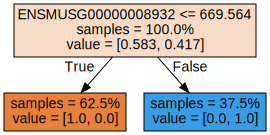

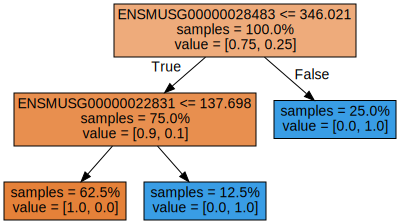

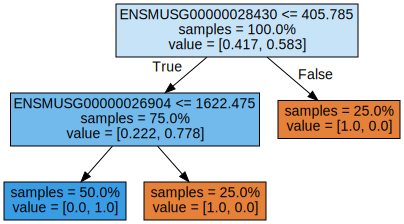

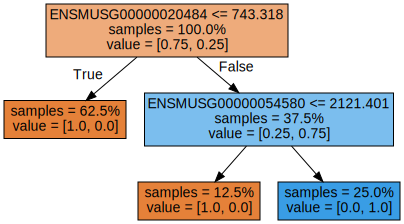

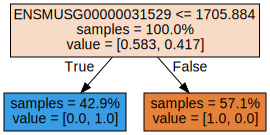

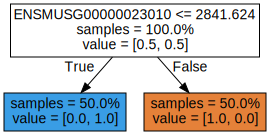

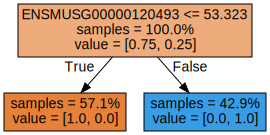

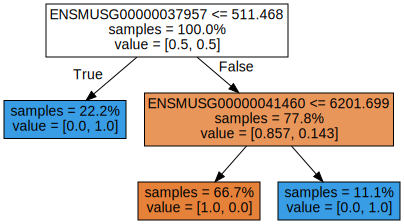

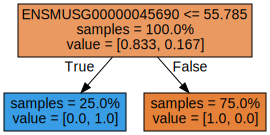

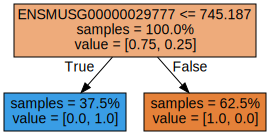

In [17]:
# visualize the random forest
num_trees=10
for i in range(num_trees):
    tree = clf.estimators_[i]
    dot_data = m.export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               impurity=False,
                               proportion=True)
    graph = m.graphviz.Source(dot_data)
    display(graph)

In [18]:
# now create a confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1, 0],
       [1, 2]])

**QUESTIONS**

1. What is the training accuracy of the random forest model? Test accuracy?

2. Which genes are used in the 5 decision trees of the random forest model?

3. According to the confusion matrix, how many low IOP samples were correctly classified?  correct high IOP?  how many low IOP samples were confused with high IOP samples?

## Build a single-layer perceptron model that predicts IOP from gene expression


In [19]:
# run random forest classification on X, y

from sklearn.linear_model import Perceptron
clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
train_acc = m.accuracy_score(y_train, y_train_pred)
print("train accuracy:", train_acc)

y_pred = clf.predict(X_test)
test_acc = m.accuracy_score(y_test, y_pred)
print("test accuracy:", test_acc)

print('overall score: ', clf.score(X, y))


train accuracy: 0.4166666666666667
test accuracy: 0.75
overall score:  0.5


**QUESTIONS**

1. What is the training accuracy of the SLP model?

2. What is the test accuracy of the SLP model?

3. What might explain the discrepancy between the training and testing accuracy?

## BONUS: Build a logistic regression model that predicts IOP from gene expression

In [20]:
# now run logistic regression classification on X, y

clf = m.LogisticRegression(random_state=23)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
train_acc = m.accuracy_score(y_train, y_train_pred)
print("train accuracy:", train_acc)

y_pred = clf.predict(X_test)
test_acc = m.accuracy_score(y_test, y_pred)
print("test accuracy:", test_acc)


train accuracy: 1.0
test accuracy: 0.5


**QUESTIONS**

1. What is the training accuracy of the logistic regression model?

2. What is the test accuracy of the logistic regression model?

3. Which model has a better test accuracy for predicting IOP from gene expression -- the random forest model, the SLP model, or the logistic regression model?

# Predict immunostaining PECAM microscopy from RNA-seq (gene expression)

Not all the samples with PECAM measurements had their RNA sequenced.  We will need to first intersect the PECAM data with samples from RNA-seq data.

## Prepare the data for the algorithms

In [21]:
# filter genes to those significantly differentially expressed between ground control and space flight
rna_seq = m.filter_by_dgea(data['255-normalized'], metadata['255'],  pval=0.05, l2fc=0)

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 42.02 seconds.

Fitting dispersion trend curve...
... done in 0.87 seconds.

Fitting MAP dispersions...
... done in 42.84 seconds.

Fitting LFCs...
... done in 21.63 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 294 outlier genes.

Fitting dispersions...
... done in 0.43 seconds.

Fitting MAP dispersions...
... done in 0.41 seconds.

Fitting LFCs...
... done in 0.28 seconds.

Running Wald tests...
... done in 5.75 seconds.



Log2 fold change & Wald test p-value: condition 0 vs 1
                      baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSMUSG00000000001  247.799812       -0.018393  0.073619 -0.249837  0.802713   
ENSMUSG00000000028   27.844661       -0.175417  0.251489 -0.697513  0.485482   
ENSMUSG00000000031    4.111510        1.098824  0.720941  1.524152  0.127471   
ENSMUSG00000000037   17.569248       -0.267676  0.292810 -0.914163  0.360631   
ENSMUSG00000000049    1.058677        2.166938  1.289496  1.680453  0.092869   
...                        ...             ...       ...       ...       ...   
ENSMUSG00002076937    3.364061       -1.001464  0.889246 -1.126194  0.260083   
ENSMUSG00002076945    1.308321        0.414447  1.081399  0.383250  0.701534   
ENSMUSG00002076971    0.684746        0.261245  1.815131  0.143926  0.885559   
ENSMUSG00002076982    0.685585       -0.263624  1.350536 -0.195200  0.845237   
ENSMUSG00002076983    0.810512       -1.684478  1.616810 -1.04185

In [22]:
# get source names from 255 and sample names in immunoMICRO pecam and intersect the lists and subset the df's
samples_255_dict = dict()
samples_pecam = list()
for i in range(len(metadata['255'])):
  sample = metadata['255'].iloc[i]['Source Name']
  num = ""
  for c in sample:
    if c.isdigit():
      num += str(c)
  if "G" in sample:
    samples_255_dict["GC" + num] = metadata['255'].iloc[i]['Sample Name']

  elif "F" in sample:
    samples_255_dict["F" + num] = metadata['255'].iloc[i]['Sample Name']
  else:
    continue

for sample in data['immunoMICRO-PECAM']['Sample_Name']:
  num = ""
  for c in sample:
    if c.isdigit():
      num += str(c)
  if "G" in sample:
    samples_pecam.append("GC" + num)
  elif "F" in sample:
    samples_pecam.append("F" + num)
  else:
    print('neither ground nor space: ',  sample)
    continue

print('255 samples: ', samples_255_dict.keys())
print('pecam samples: ', samples_pecam)
# intersect 255 samples with immunoMICRO pecam samples
samples_both=list(set(samples_255_dict.keys()) & set(samples_pecam))
print('both: ', samples_both)
# subset 255 and pecam samples from intersection
gsm_samples = list()
for sample in samples_both:
  gsm_samples.append(samples_255_dict[sample])
print('gsm: ', gsm_samples)

255 samples:  dict_keys(['GC9', 'GC11', 'GC15', 'GC16', 'GC17', 'GC18', 'GC19', 'GC20', 'F9', 'F11', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20'])
pecam samples:  ['F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'GC15', 'GC16', 'GC17', 'GC18', 'GC19']
both:  ['F15', 'F17', 'F18', 'F16', 'GC17', 'GC15', 'F20', 'F19', 'GC19', 'GC16', 'GC18']
gsm:  ['GSM3932703', 'GSM3932705', 'GSM3932706', 'GSM3932704', 'GSM3932697', 'GSM3932695', 'GSM3932708', 'GSM3932707', 'GSM3932699', 'GSM3932696', 'GSM3932698']


In [23]:
# now subset the rna_seq dataframe with samples from the gsm_samples list
X = rna_seq[['Unnamed: 0'] + gsm_samples]
print(X.columns)

Index(['Unnamed: 0', 'GSM3932703', 'GSM3932705', 'GSM3932706', 'GSM3932704',
       'GSM3932697', 'GSM3932695', 'GSM3932708', 'GSM3932707', 'GSM3932699',
       'GSM3932696', 'GSM3932698'],
      dtype='object')


In [24]:
# subset the pecam data frame with samples from the both list
samples_pecam

['F15',
 'F16',
 'F17',
 'F18',
 'F19',
 'F20',
 'GC15',
 'GC16',
 'GC17',
 'GC18',
 'GC19']

In [25]:
# create numpy array Y of immuno PECAM values
y = list()
for i in range(len(data['immunoMICRO-PECAM'])):
  pecam_val=data['immunoMICRO-PECAM'].iloc[i]['Average']
  print('sample: ', data['immunoMICRO-PECAM'].iloc[i]['Sample_Name'])
  y.append(pecam_val)

y = m.np.array(y)
y_classes = list()
for p in y:
  if p > y.mean():
    y_classes.append(1)
  else:
    y_classes.append(0)

y = y_classes
print('y = ', y)

sample:  F15_Mouse_Eye
sample:  F16_Mouse_Eye
sample:  F17_Mouse_Eye
sample:  F18_Mouse_Eye
sample:  F19_Mouse_Eye
sample:  F20_Mouse_Eye
sample:  GC15_Mouse_Eye
sample:  GC16_Mouse_Eye
sample:  GC17_Mouse_Eye
sample:  GC18_Mouse_Eye
sample:  GC19_Mouse_Eye
y =  [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0]


In [26]:
# create numpy array X of rna-seq values
X = m.transpose_df(X, 'Unnamed: 0', 'sample').drop(columns=['sample'])

In [27]:
# split up data into training and testing subsets
X_train, X_test, y_train, y_test = m.train_test_split(X, y, test_size=0.2, random_state=0)

In [28]:
# show the dimensions of the training and testing data
print('X train: ', X_train.shape)
print('y train: ', len(y_train))
print('X test: ', X_test.shape)
print('y test: ', len(y_test))

X train:  (8, 353)
y train:  8
X test:  (3, 353)
y test:  3


**QUESTIONS**

1. How many samples are used for training the model?

2. How many samples are used for testing the model?

3. Based on the number of samples for testing, what are the possible accuracy scores?

## Build a random forest model to predict PECAM microscopy from gene expression

In [29]:
# now run classification on X, y
max_depth=4
clf = m.RandomForestClassifier(max_depth=max_depth, random_state=23)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
train_acc = m.accuracy_score(y_train, y_train_pred)
print("train accuracy:", train_acc)

y_pred = clf.predict(X_test)
accuracy = m.accuracy_score(y_test, y_pred)
print("test accuracy:", accuracy)

train accuracy: 1.0
test accuracy: 0.3333333333333333


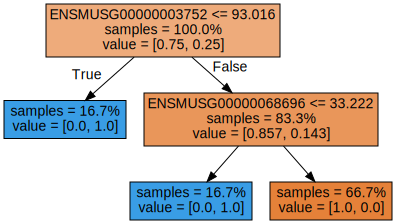

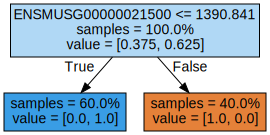

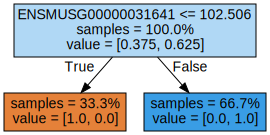

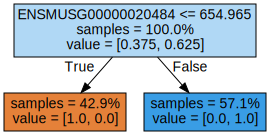

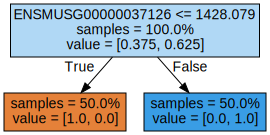

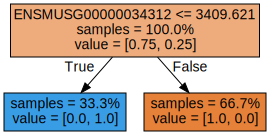

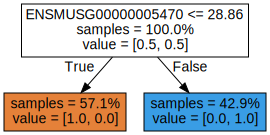

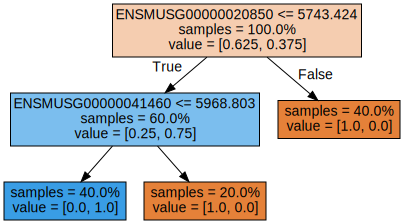

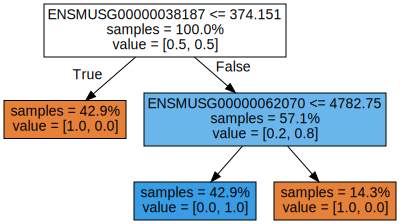

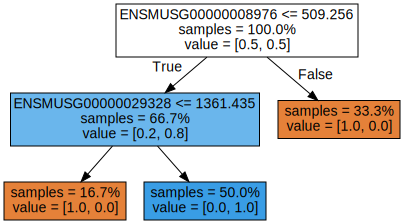

In [30]:
# visualize forest / feature importance
num_trees=10
for i in range(num_trees):
    tree = clf.estimators_[i]
    dot_data = m.export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               impurity=False,
                               proportion=True)
    graph = m.graphviz.Source(dot_data)
    display(graph)

**QUESTIONS**

1. What is training accuracy of the random forest model?

2. What is the test accuracy of the random forest model?

3. Which genes are used in the decision trees of the random forest?

## BONUS: Build a logistic regression model to predict PECAM microscopy from gene expression

In [31]:
# now run classification on X, y

clf = m.LogisticRegression(random_state=23)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
train_acc = m.accuracy_score(y_train, y_train_pred)
print("train accuracy:", train_acc)

y_pred = clf.predict(X_test)
accuracy = m.accuracy_score(y_test, y_pred)
print("test accuracy:", accuracy)

train accuracy: 1.0
test accuracy: 0.3333333333333333


**QUESTIONS**

1. What is the training accuracy of the logistic regression model?

2. What is the test accuracy of the logistic regression model?

3. Which model has a better test accuracy for predicting PECAM microscopy from gene expression -- the random forest model, the SLP model, or the logistic regression model?